In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings

warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500["Symbol"].unique().tolist()

end_date = "2025-06-04"
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*7)

df = yf.download(tickers=symbols_list,
                start=start_date,
                end=end_date,
                auto_adjust=False).stack()

df.index.names = ["date", "ticker"]

df.columns = df.columns.str.lower()

df



[*********************100%***********************]  502 of 502 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2018-06-06 A        61.768730   65.190002   65.190002   63.060001   63.750000   
           AAPL     45.886036   48.494999   48.520000   47.980000   48.407501   
           ABBV     73.416763   99.980003   99.989998   98.320000   99.250000   
           ABT      56.237671   63.540001   63.549999   62.779999   63.110001   
           ACGL     25.864441   27.200001   27.286667   26.836666   27.086666   
...                       ...         ...         ...         ...         ...   
2025-06-03 XYL     127.150002  127.150002  127.620003  125.089996  125.669998   
           YUM     143.970001  143.970001  144.589996  141.429993  143.979996   
           ZBH      91.612427   91.849998   92.400002   89.220001   90.529999   
           ZBRA    291.989990  291.989990  292.179993  282.739990  286.279999   
           ZTS     170.300003  170.300003  172.229996  168.639999  169.089996   

Price                  volume  
date       ticker              
2018-06-06 A        3177600.0  
           AAPL    83734400.0  
           ABBV     4933500.0  
           ABT      4064400.0  
           ACGL     4060500.0  
...                       ...  
2025-06-03 XYL       949100.0  
           YUM      2414900.0  
           ZBH      1381600.0  
           ZBRA      641500.0  
           ZTS      3149000.0  

[867849 rows x 6 columns]

In [2]:
df['garman_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2
    - (2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open'])) ** 2
)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(
    lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0]
)

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(
    lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1]
)

df['bb_high'] = df.groupby(level=1)['adj close'].transform(
    lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2]
)

def compute_atr(stock_data):
    atr = pandas_ta.atr(
        high=stock_data['high'],
        low=stock_data['low'],
        close=stock_data['close'],
        length=14
    )
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)


def compute_macd(close):
    macd_df = pandas_ta.macd(close=close, length=20)
    if macd_df is not None and not macd_df.empty:
        macd = macd_df.iloc[:, 0]
        return macd.sub(macd.mean()).div(macd.std())
    else:
        return pd.Series(index=close.index, data=np.nan)

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)


df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df



Price               adj close       close        high         low        open  \
date       ticker                                                               
2018-06-06 A        61.768730   65.190002   65.190002   63.060001   63.750000   
           AAPL     45.886036   48.494999   48.520000   47.980000   48.407501   
           ABBV     73.416763   99.980003   99.989998   98.320000   99.250000   
           ABT      56.237671   63.540001   63.549999   62.779999   63.110001   
           ACGL     25.864441   27.200001   27.286667   26.836666   27.086666   
...                       ...         ...         ...         ...         ...   
2025-06-03 XYL     127.150002  127.150002  127.620003  125.089996  125.669998   
           YUM     143.970001  143.970001  144.589996  141.429993  143.979996   
           ZBH      91.612427   91.849998   92.400002   89.220001   90.529999   
           ZBRA    291.989990  291.989990  292.179993  282.739990  286.279999   
           ZTS     170.300003  170.300003  172.229996  168.639999  169.089996   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-06-06 A        3177600.0          0.000167        NaN       NaN   
           AAPL    83734400.0         -0.001043        NaN       NaN   
           ABBV     4933500.0         -0.034971        NaN       NaN   
           ABT      4064400.0         -0.005060        NaN       NaN   
           ACGL     4060500.0         -0.000685        NaN       NaN   
...                       ...               ...        ...       ...   
2025-06-03 XYL       949100.0          0.000148  59.474638  4.803752   
           YUM      2414900.0          0.000244  45.144142  4.965507   
           ZBH      1381600.0          0.000559  40.198595  4.510024   
           ZBRA      641500.0          0.000389  56.096477  5.556490   
           ZTS      3149000.0          0.000202  61.035737  5.035530   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2018-06-06 A            NaN       NaN       NaN       NaN     196.276317  
           AAPL         NaN       NaN       NaN       NaN    3842.239686  
           ABBV         NaN       NaN       NaN       NaN     362.201602  
           ABT          NaN       NaN       NaN       NaN     228.572390  
           ACGL         NaN       NaN       NaN       NaN     105.022562  
...                     ...       ...       ...       ...            ...  
2025-06-03 XYL     4.836951  4.870149  0.014942  0.935138     120.678066  
           YUM     4.988828  5.012148  0.628940 -0.749680     347.673156  
           ZBH     4.553485  4.596947 -0.361261 -0.917853     126.571729  
           ZBRA    5.661991  5.767493 -0.081041  0.792517     187.311579  
           ZTS     5.095808  5.156087  0.312697  1.142639     536.274710  

[867849 rows x 14 columns]

In [3]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2018-07-31 A          109.863467   62.725246          0.000076  58.789567   
           AAPL      3377.193105   45.013172         -0.001076  49.490737   
           ABBV       474.892490   68.417503         -0.032916  45.492591   
           ABT        292.554709   58.268562         -0.005079  63.283584   
           ACGL        38.038162   29.059458         -0.000716  81.322994   
...                          ...         ...               ...        ...   
2025-06-30 XYL        147.248011  127.150002          0.000148  59.474638   
           YUM        301.458094  143.970001          0.000244  45.144142   
           ZBH        138.175411   91.612427          0.000559  40.198595   
           ZBRA       165.674813  291.989990          0.000389  56.096477   
           ZTS        484.156323  170.300003          0.000202  61.035737   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2018-07-31 A       4.076660  4.120545  4.164429 -1.629408  0.139042  
           AAPL    3.803619  3.829757  3.855896 -1.537085 -0.164809  
           ABBV    4.199504  4.252961  4.306419 -0.380384 -0.585986  
           ABT     4.001632  4.048514  4.095396 -1.604256  0.354122  
           ACGL    3.271822  3.342352  3.412882 -1.233976  0.530182  
...                     ...       ...       ...       ...       ...  
2025-06-30 XYL     4.803752  4.836951  4.870149  0.014942  0.935138  
           YUM     4.965507  4.988828  5.012148  0.628940 -0.749680  
           ZBH     4.510024  4.553485  4.596947 -0.361261 -0.917853  
           ZBRA    5.556490  5.661991  5.767493 -0.081041  0.792517  
           ZTS     5.035530  5.095808  5.156087  0.312697  1.142639  

[41471 rows x 9 columns]

In [4]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-06-30 AAPL     47.530727         -0.000672  56.282134  3.781842   
           ABBV     55.922279         -0.020365  42.046318  3.983328   
           ABT      75.733627         -0.003883  64.665776  4.254858   
           ACN     169.383636         -0.002625  58.459429  5.099023   
           ADBE    294.649994          0.000057  58.679787  5.566200   
...                       ...               ...        ...       ...   
2025-06-30 VZ       43.830002          0.000048  52.697509  3.773702   
           WDAY    251.119995          0.000172  50.533830  5.454521   
           WFC      75.650002          0.000130  59.202950  4.289111   
           WMT      99.980003          0.000264  61.298562  4.566625   
           XOM     103.800003          0.000251  46.105076  4.621128   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2019-06-30 AAPL    3.856704  3.931566 -1.369146  0.006054  
           ABBV    4.084980  4.186631 -0.284366 -0.903710  
           ABT     4.315521  4.376183 -1.259640  0.887813  
           ACN     5.129683  5.160344 -1.335705  0.158279  
           ADBE    5.645850  5.725500 -1.238701  0.431184  
...                     ...       ...       ...       ...  
2025-06-30 VZ      3.796893  3.820084 -0.389827  0.186591  
           WDAY    5.556375  5.658229  0.377794 -0.079432  
           WFC     4.323002  4.356892  1.020878  0.972082  
           WMT     4.589927  4.613229  2.549756  1.185584  
           XOM     4.662412  4.703697  0.252565 -0.886416  

[10877 rows x 8 columns]

In [5]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2020-06-30 AAPL     88.652695          0.000045  65.114767  4.374285   
           ABBV     79.996490         -0.012312  62.227278  4.323442   
           ABT      83.677414         -0.000602  52.316791  4.393046   
           ACN     199.344971         -0.001413  59.849979  5.208965   
           ADBE    435.309998          0.000305  63.890663  5.939866   
...                       ...               ...        ...       ...   
2025-06-30 VZ       43.830002          0.000048  52.697509  3.773702   
           WDAY    251.119995          0.000172  50.533830  5.454521   
           WFC      75.650002          0.000130  59.202950  4.289111   
           WMT      99.980003          0.000264  61.298562  4.566625   
           XOM     103.800003          0.000251  46.105076  4.621128   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2020-06-30 AAPL    4.449003  4.523721 -0.569546  0.884131   0.147386   
           ABBV    4.364506  4.405571 -0.191195  0.518587   0.059459   
           ABT     4.423246  4.453446  0.966641 -0.391428  -0.036768   
           ACN     5.260249  5.311534  0.210808  0.768789   0.064974   
           ADBE    6.026593  6.113320 -0.002840  1.389984   0.125996   
...                     ...       ...       ...       ...        ...   
2025-06-30 VZ      3.796893  3.820084 -0.389827  0.186591  -0.002957   
           WDAY    5.556375  5.658229  0.377794 -0.079432   0.013766   
           WFC     4.323002  4.356892  1.020878  0.972082   0.011634   
           WMT     4.589927  4.613229  2.549756  1.185584   0.012763   
           XOM     4.662412  4.703697  0.252565 -0.886416   0.014663   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2020-06-30 AAPL     0.115806   0.128842   0.037699   0.056647    0.053319  
           ABBV     0.092888   0.093582   0.022171   0.034178    0.030285  
           ABT     -0.003590   0.051786   0.010002   0.011301    0.008347  
           ACN      0.076781   0.095219   0.004657   0.013723    0.013665  
           ADBE     0.109478   0.110064   0.047343   0.051826    0.033057  
...                      ...        ...        ...        ...         ...  
2025-06-30 VZ      -0.002613  -0.006107   0.021084   0.002742    0.010566  
           WDAY     0.012413   0.024502  -0.004514   0.003014    0.009735  
           WFC      0.034982   0.019468   0.014199   0.034837    0.022392  
           WMT      0.015164   0.045135   0.017898   0.024858    0.033891  
           XOM     -0.004146  -0.041418  -0.002930  -0.010536   -0.005753  

[8722 rows x 14 columns]

In [6]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2020-06-30 AAPL    0.0244  0.0195 -0.0217  0.0014  0.0055   0.147386
           ABBV    0.0244  0.0195 -0.0217  0.0014  0.0055   0.059459
           ABT     0.0244  0.0195 -0.0217  0.0014  0.0055  -0.036768
           ACN     0.0244  0.0195 -0.0217  0.0014  0.0055   0.064974
           ADBE    0.0244  0.0195 -0.0217  0.0014  0.0055   0.125996
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[8443 rows x 6 columns]

In [7]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2020-06-30 AAPL    0.0244  0.0195 -0.0217  0.0014  0.0055   0.147386
           ABBV    0.0244  0.0195 -0.0217  0.0014  0.0055   0.059459
           ABT     0.0244  0.0195 -0.0217  0.0014  0.0055  -0.036768
           ACN     0.0244  0.0195 -0.0217  0.0014  0.0055   0.064974
           ADBE    0.0244  0.0195 -0.0217  0.0014  0.0055   0.125996
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[8410 rows x 6 columns]

In [8]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2020-06-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-04-30 VZ      0.906433 -1.068524  0.905052  0.657367 -0.069284
           WDAY    1.108715 -0.937077  0.037348 -1.896113 -0.421493
           WFC     0.877758 -0.095225  0.559150 -1.655162 -0.085207
           WMT     0.787357  0.091258 -0.722490  0.394617  0.633472
           XOM     0.476822 -0.287361  1.039672  1.215639  0.114549

[8410 rows x 5 columns]

In [9]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = data.drop(columns=factors, errors='ignore')
data = data.join(betas.groupby('ticker').shift())
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)
data = data.dropna()
data.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8510 entries, (Timestamp('2020-06-30 00:00:00'), 'AAPL') to (Timestamp('2025-06-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  8510 non-null   float64
 1   rsi               8510 non-null   float64
 2   bb_low            8510 non-null   float64
 3   bb_mid            8510 non-null   float64
 4   bb_high           8510 non-null   float64
 5   atr               8510 non-null   float64
 6   macd              8510 non-null   float64
 7   return_1m         8510 non-null   float64
 8   return_2m         8510 non-null   float64
 9   return_3m         8510 non-null   float64
 10  return_6m         8510 non-null   float64
 11  return_9m         8510 non-null   float64
 12  return_12m        8510 non-null   float64
 13  Mkt-RF            8510 non-null   float64
 14  SMB               8510 non-null   float64
 15  HML        

In [10]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [11]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1, errors='ignore')

def get_clusters(df):
    model = KMeans(n_clusters=4, random_state=0, init=initial_centroids, n_init=1)
    df['cluster'] = model.fit(df).labels_

    rsi_index = df.columns.get_loc('rsi')

    centroids = model.cluster_centers_
    sorted_cluster_ids = np.argsort(centroids[:, rsi_index])

    label_map = {original: new for new, original in enumerate(sorted_cluster_ids)}

    df['cluster'] = df['cluster'].map(label_map)

    return df


data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2020-06-30 AAPL            0.000045  65.114767  4.374285  4.449003  4.523721   
           ABBV           -0.012312  62.227278  4.323442  4.364506  4.405571   
           ABT            -0.000602  52.316791  4.393046  4.423246  4.453446   
           ACN            -0.001413  59.849979  5.208965  5.260249  5.311534   
           ADBE            0.000305  63.890663  5.939866  6.026593  6.113320   
...                             ...        ...       ...       ...       ...   
2025-06-30 VZ              0.000048  52.697509  3.773702  3.796893  3.820084   
           WDAY            0.000172  50.533830  5.454521  5.556375  5.658229   
           WFC             0.000130  59.202950  4.289111  4.323002  4.356892   
           WMT             0.000264  61.298562  4.566625  4.589927  4.613229   
           XOM             0.000251  46.105076  4.621128  4.662412  4.703697   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2020-06-30 AAPL   -0.569546  0.884131   0.147386   0.115806   0.128842   
           ABBV   -0.191195  0.518587   0.059459   0.092888   0.093582   
           ABT     0.966641 -0.391428  -0.036768  -0.003590   0.051786   
           ACN     0.210808  0.768789   0.064974   0.076781   0.095219   
           ADBE   -0.002840  1.389984   0.125996   0.109478   0.110064   
...                     ...       ...        ...        ...        ...   
2025-06-30 VZ     -0.389827  0.186591  -0.002957  -0.002613  -0.006107   
           WDAY    0.377794 -0.079432   0.013766   0.012413   0.024502   
           WFC     1.020878  0.972082   0.011634   0.034982   0.019468   
           WMT     2.549756  1.185584   0.012763   0.015164   0.045135   
           XOM     0.252565 -0.886416   0.014663  -0.004146  -0.041418   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2020-06-30 AAPL     0.037699   0.056647    0.053319  1.165896  0.004728   
           ABBV     0.022171   0.034178    0.030285  0.481995 -0.078471   
           ABT      0.010002   0.011301    0.008347  0.775754 -0.020183   
           ACN      0.004657   0.013723    0.013665  1.150922 -0.224313   
           ADBE     0.047343   0.051826    0.033057  1.546331 -0.806158   
...                      ...        ...         ...       ...       ...   
2025-06-30 VZ       0.021084   0.002742    0.010566  0.516592 -0.557085   
           WDAY    -0.004514   0.003014    0.009735  1.134316 -0.798516   
           WFC      0.014199   0.034837    0.022392  1.066500 -0.029231   
           WMT      0.017898   0.024858    0.033891  0.673840 -0.154716   
           XOM     -0.002930  -0.010536   -0.005753  0.845029 -0.224659   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2020-06-30 AAPL   -0.597836  0.380733  0.131478        3  
           ABBV   -0.036604  0.199566  0.834975        3  
           ABT    -0.282832  0.083902  0.942019        1  
           ACN    -0.242236  0.061135 -0.101331        2  
           ADBE   -0.097546  0.203427 -0.371413        3  
...                     ...       ...       ...      ...  
2025-06-30 VZ      0.505502  0.225717 -0.096375        1  
           WDAY   -0.348842 -1.239331 -0.294830        1  
           WFC     1.595165 -0.740813 -1.158031        2  
           WMT    -0.368242  0.354530  0.432987        2  
           XOM     0.968377 -0.144820  0.351206        0  

[8510 rows x 19 columns]

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

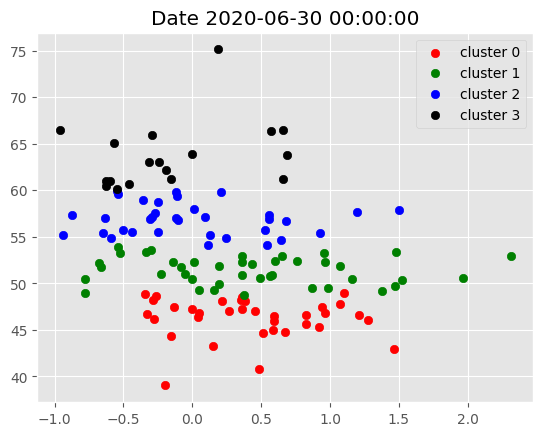

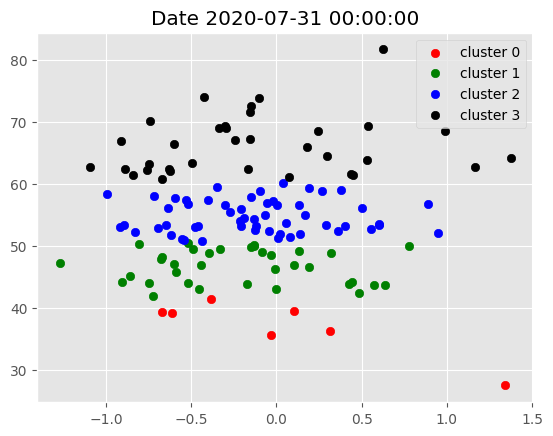

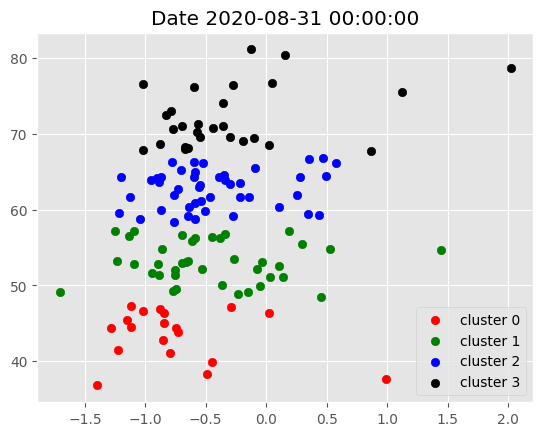

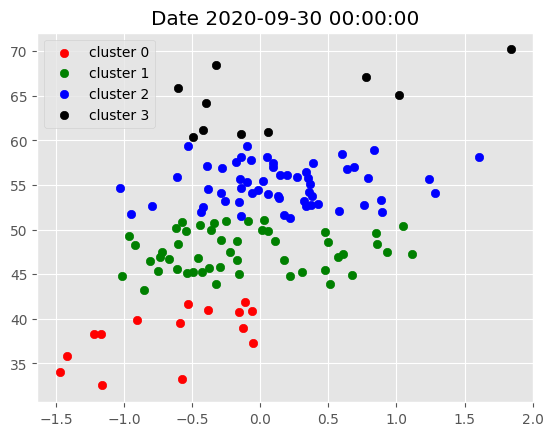

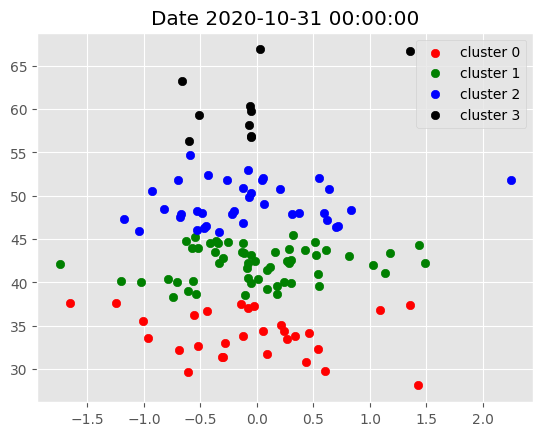

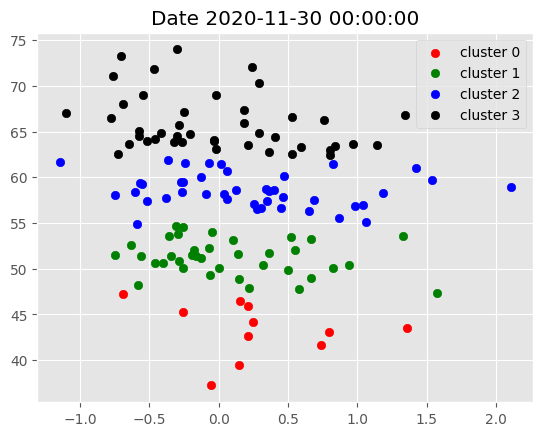

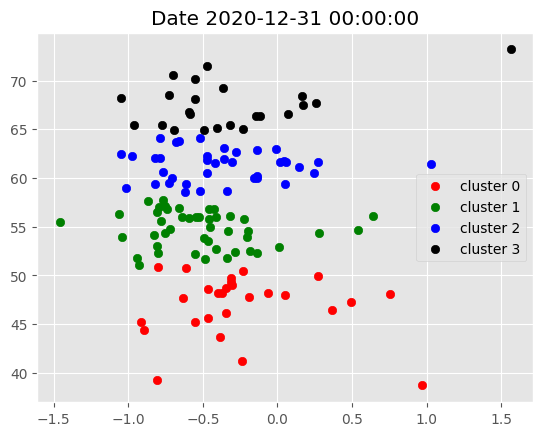

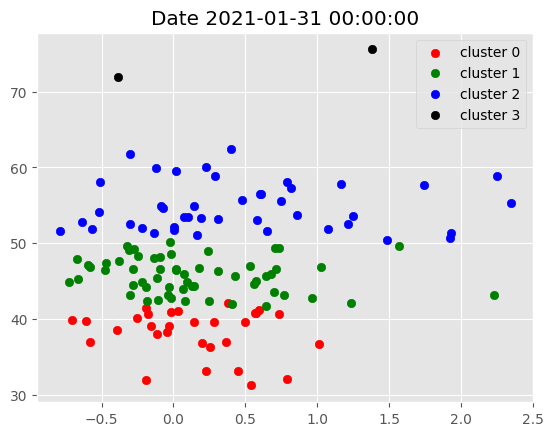

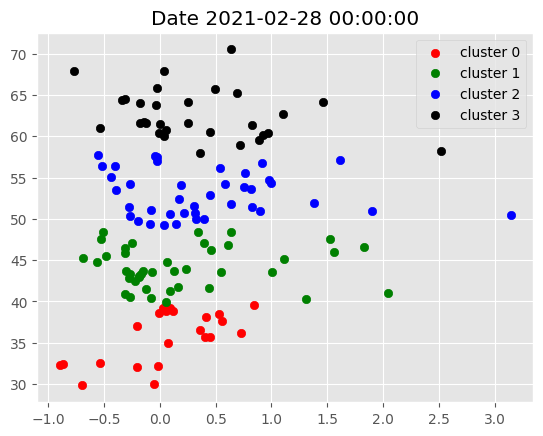

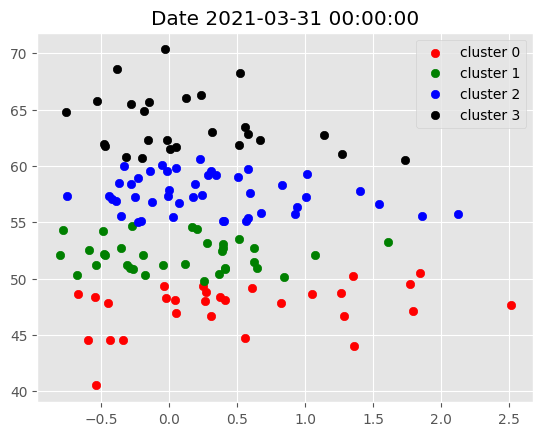

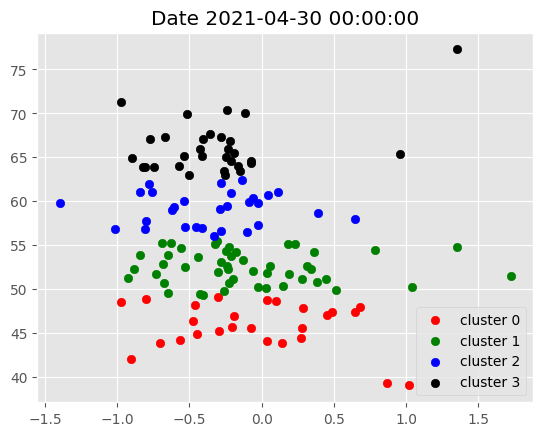

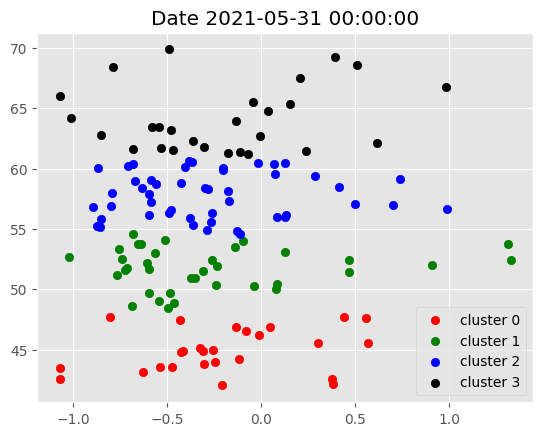

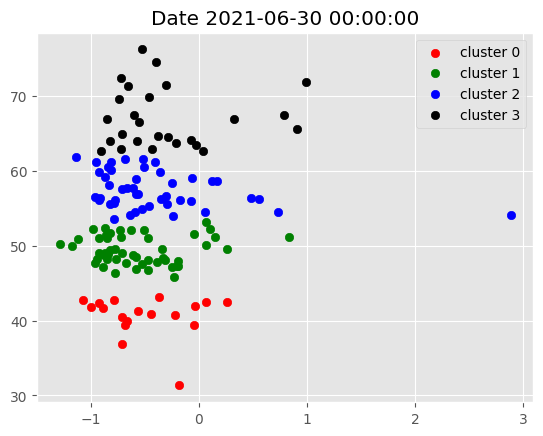

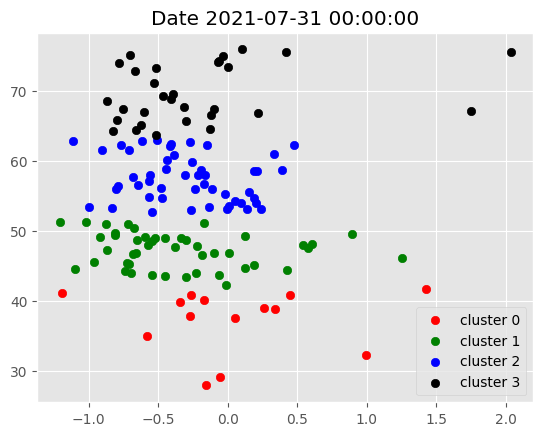

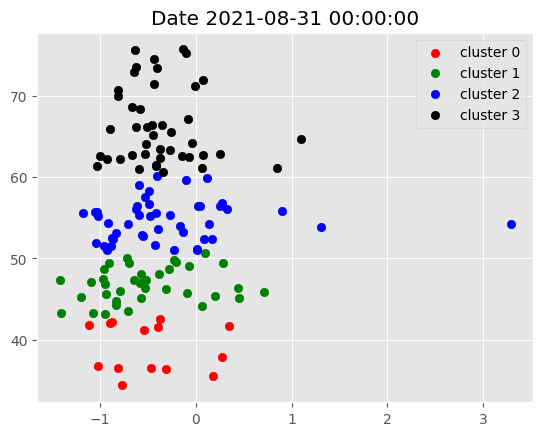

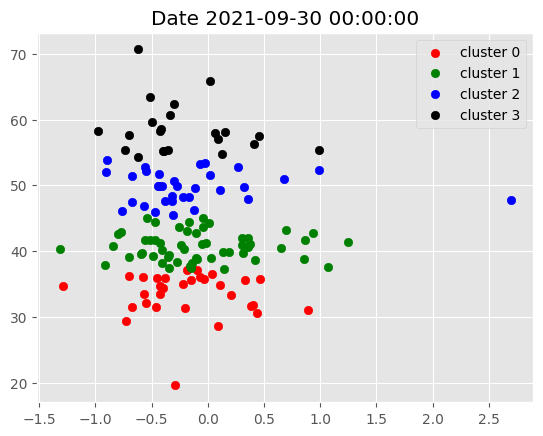

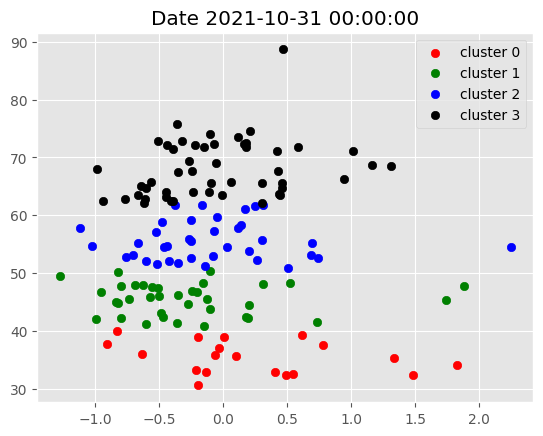

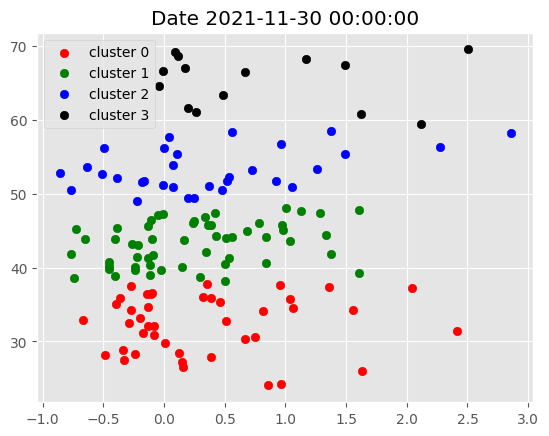

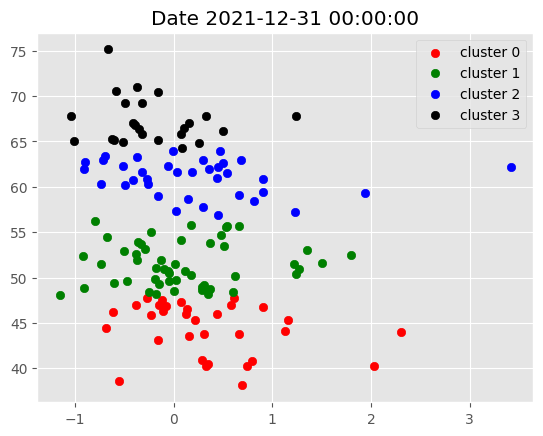

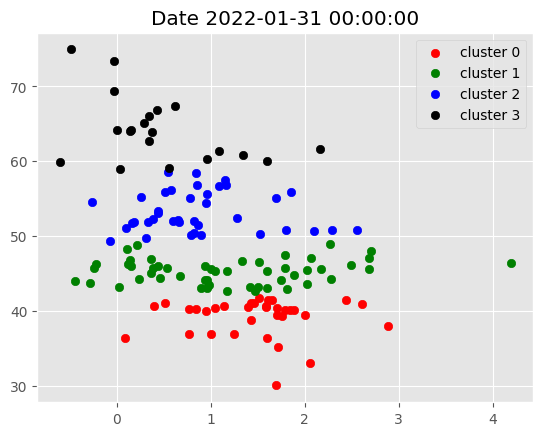

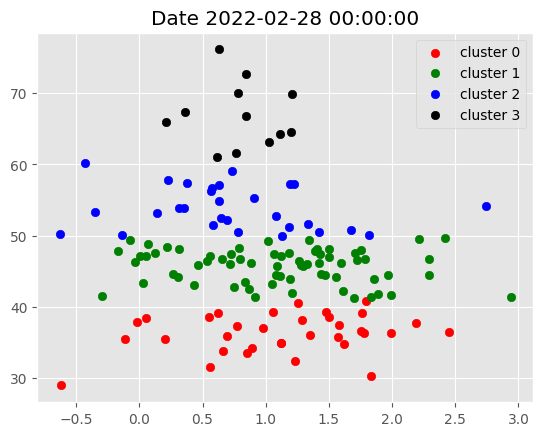

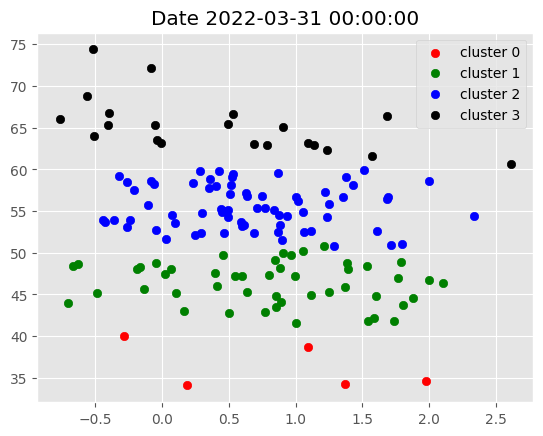

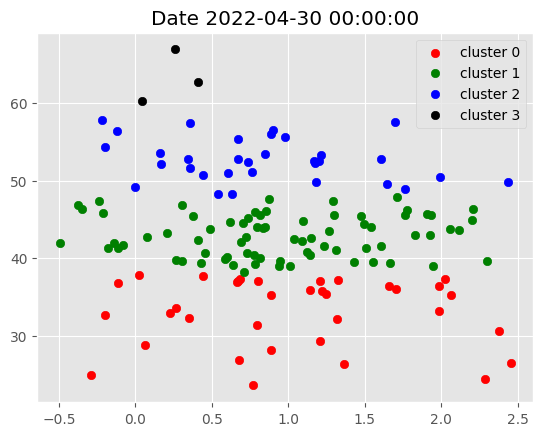

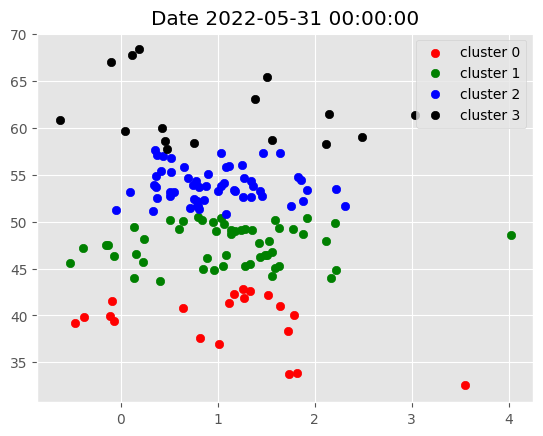

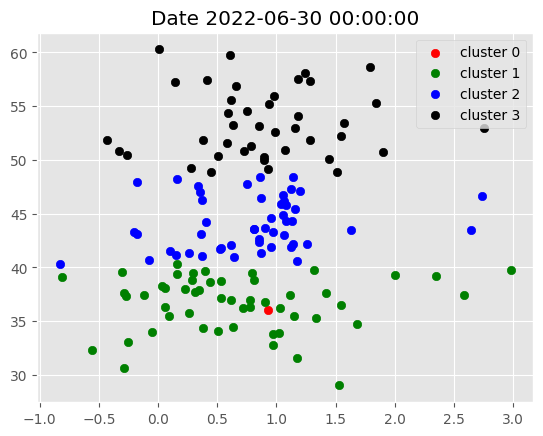

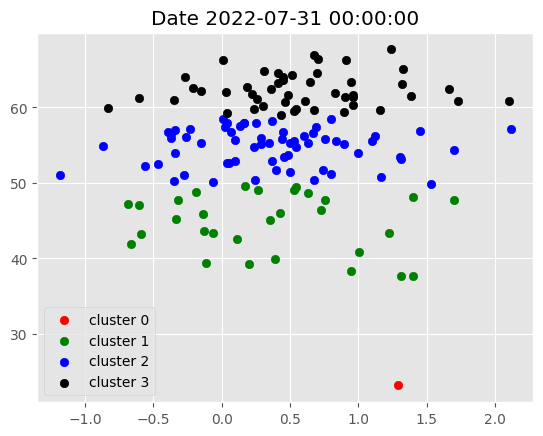

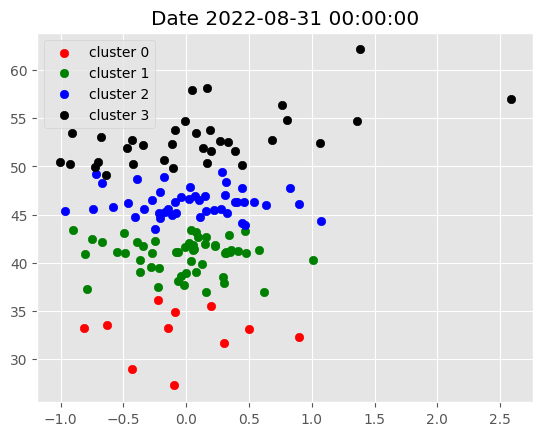

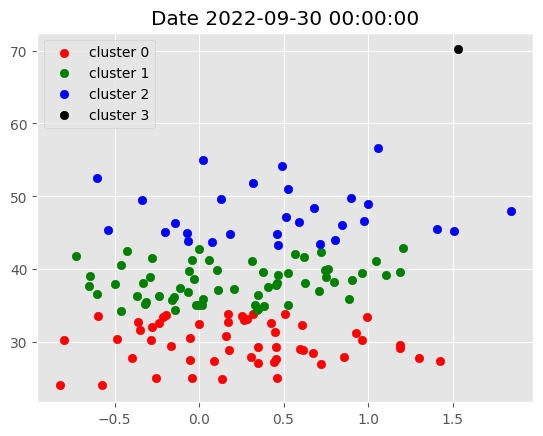

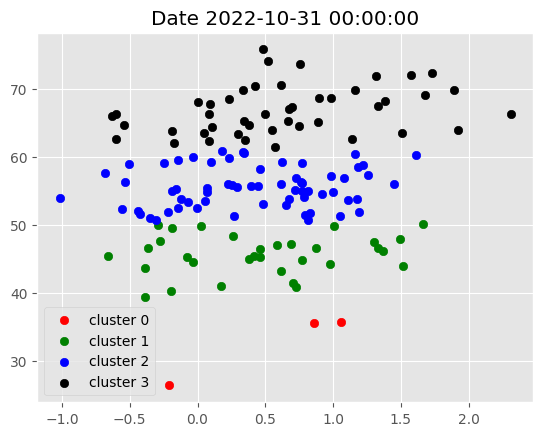

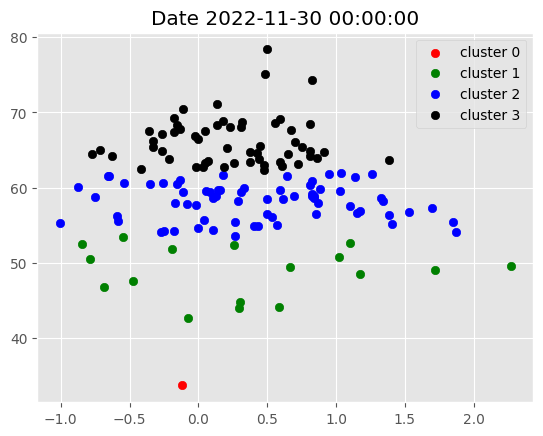

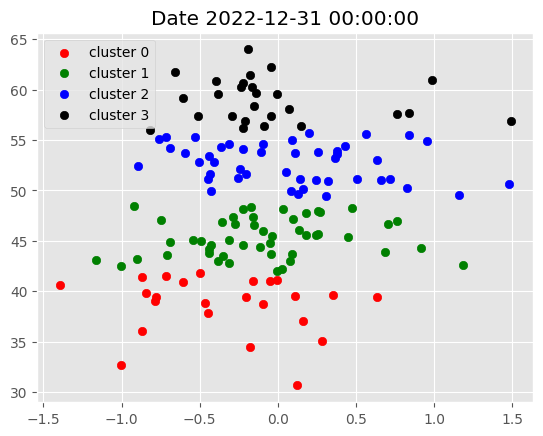

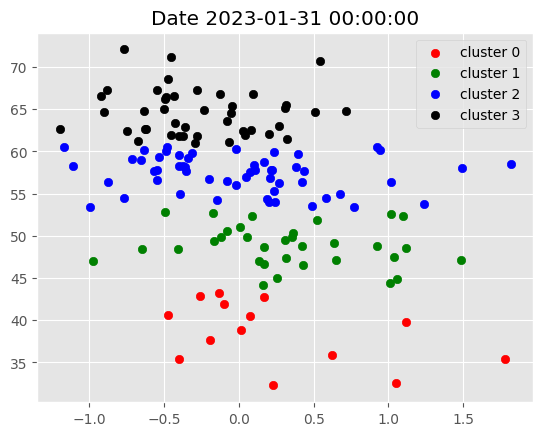

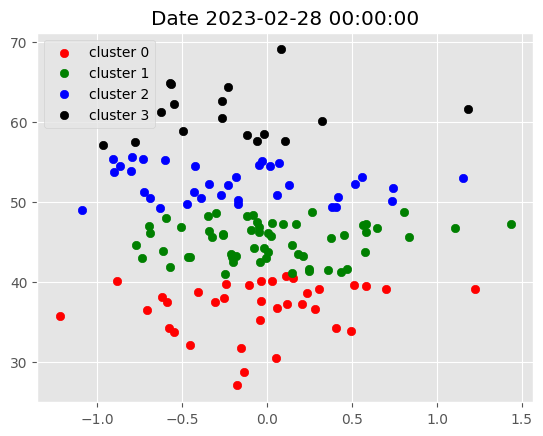

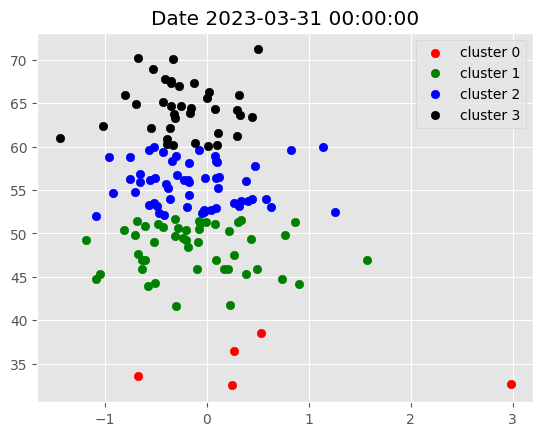

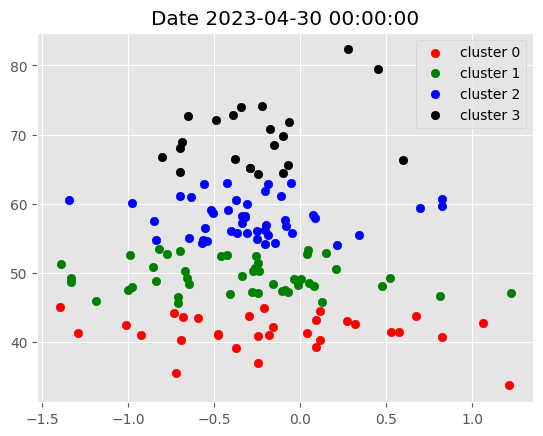

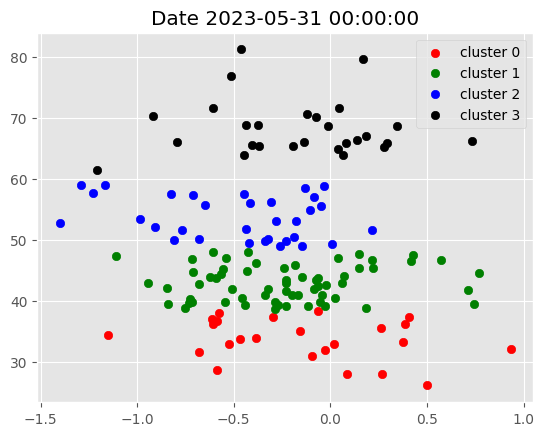

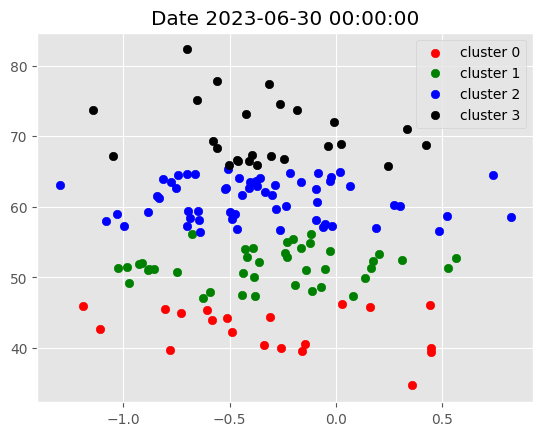

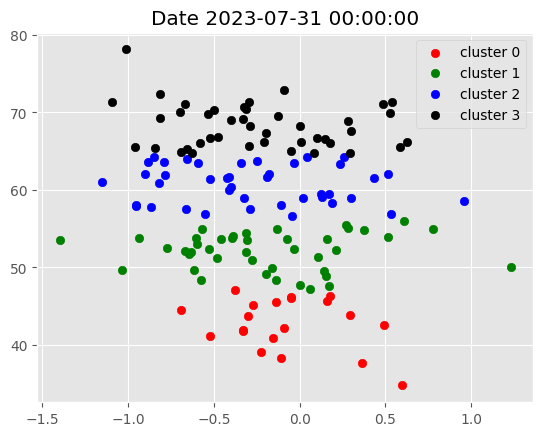

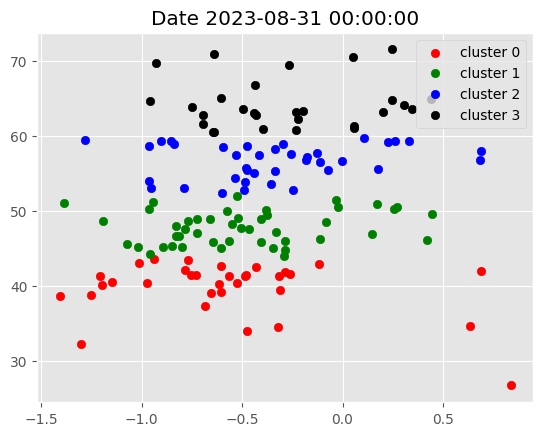

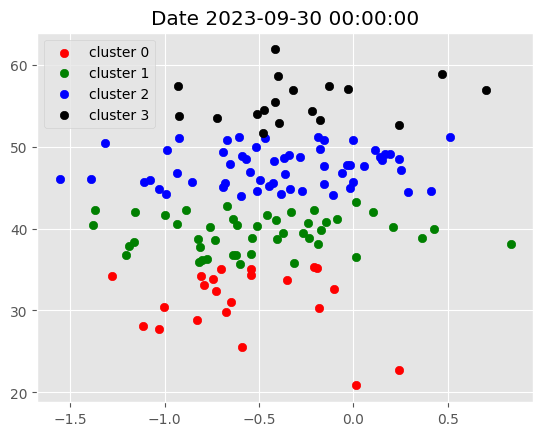

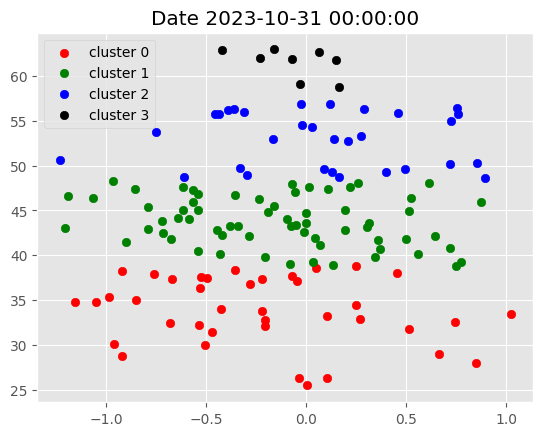

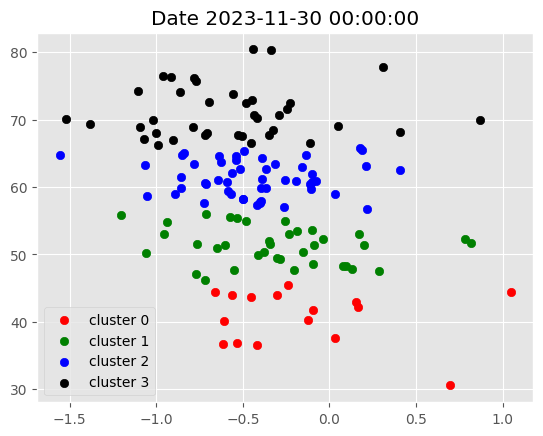

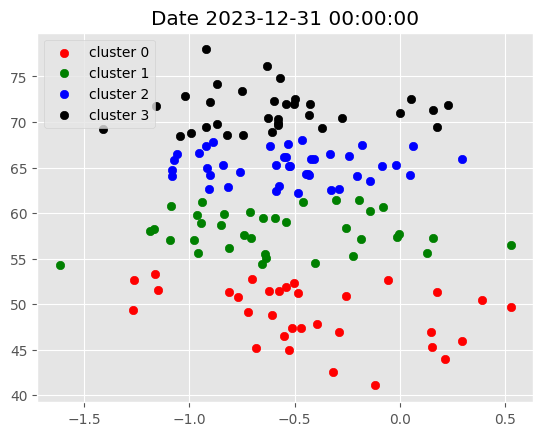

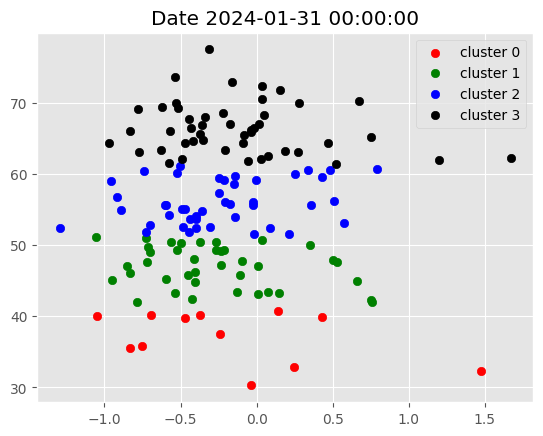

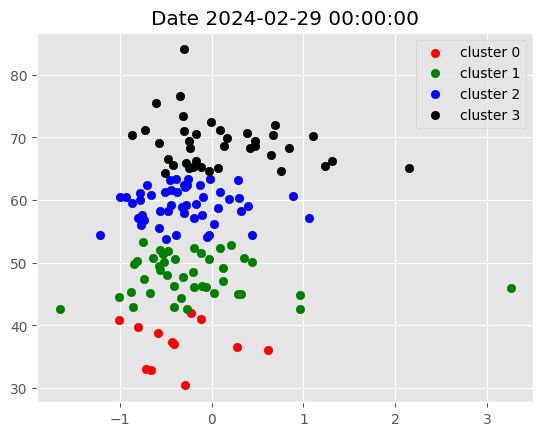

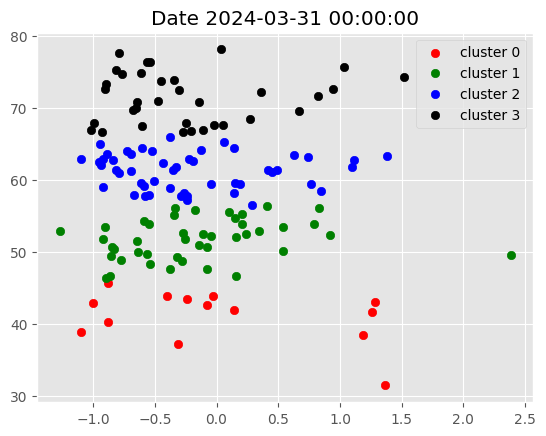

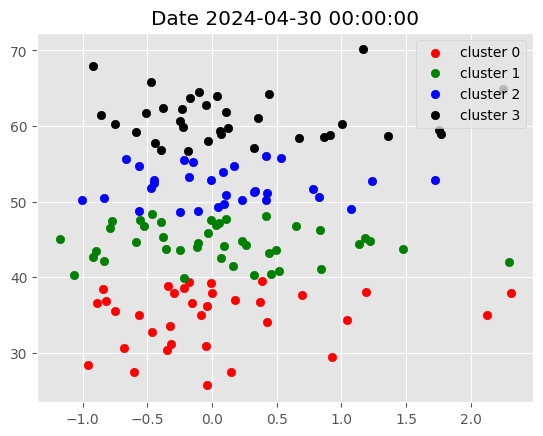

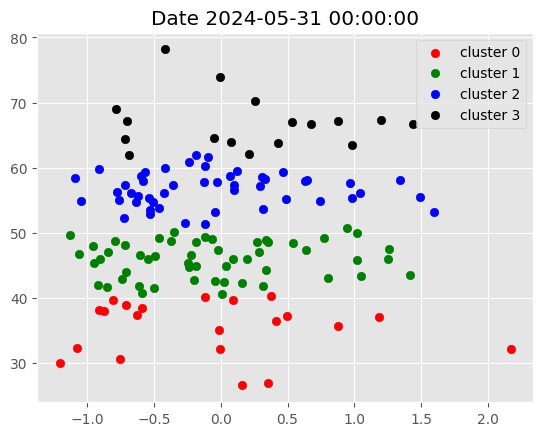

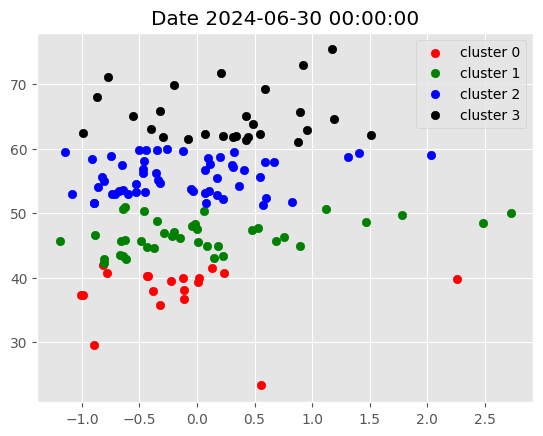

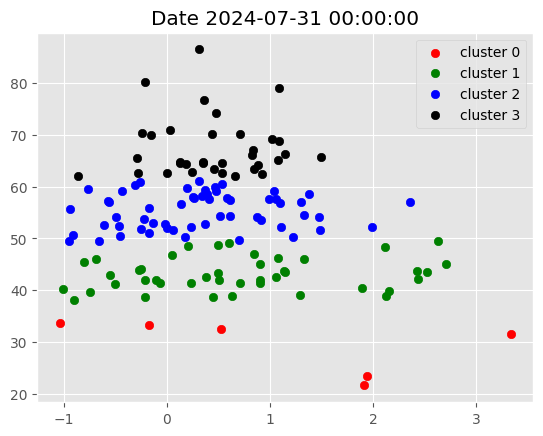

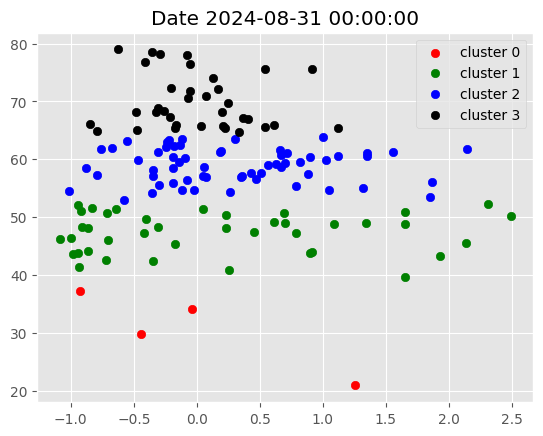

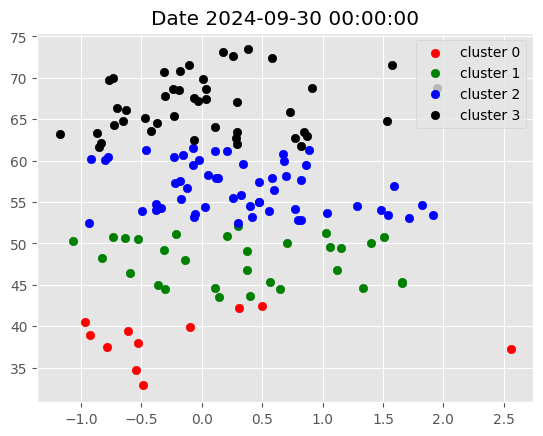

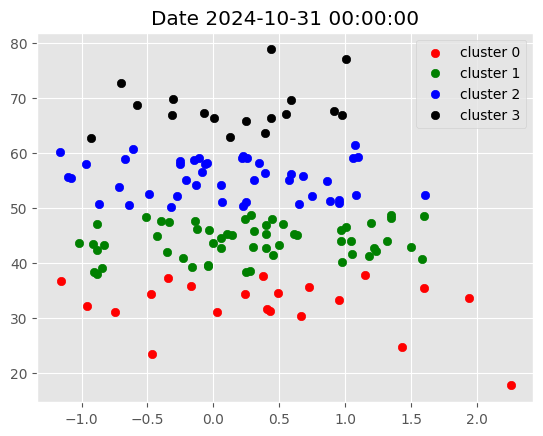

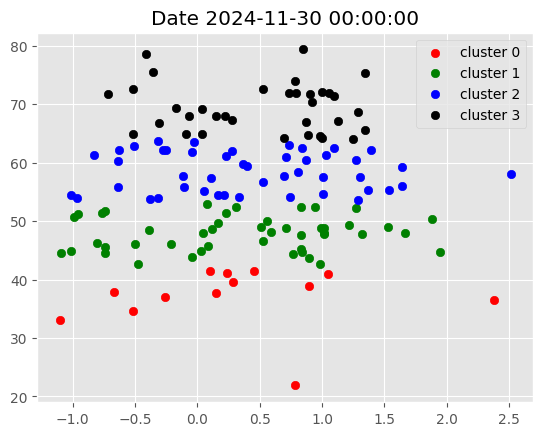

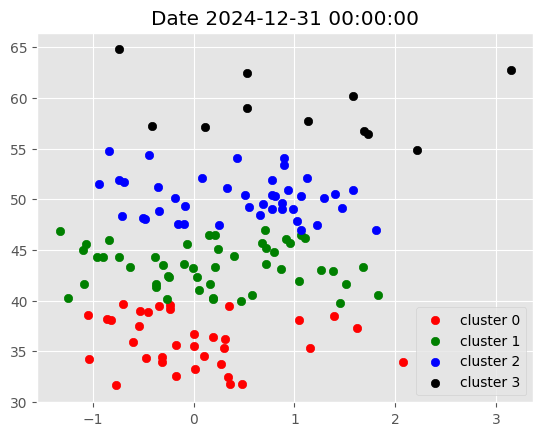

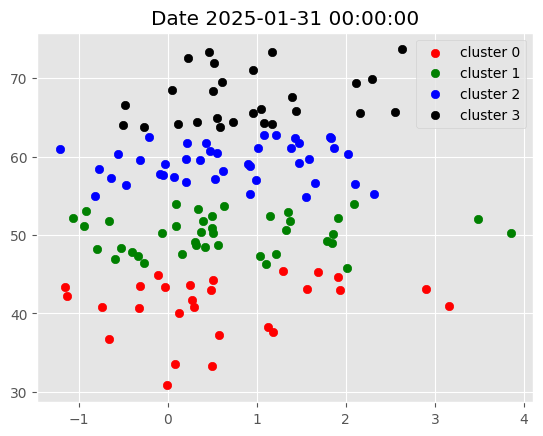

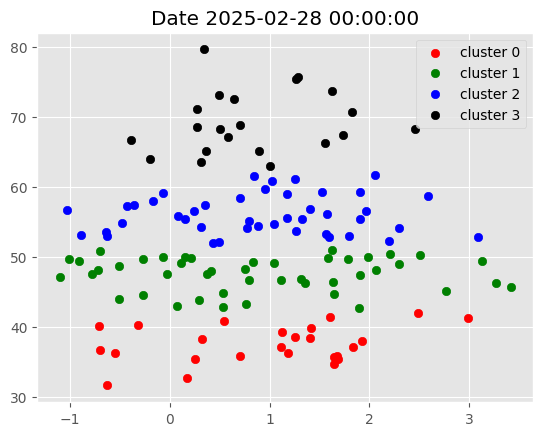

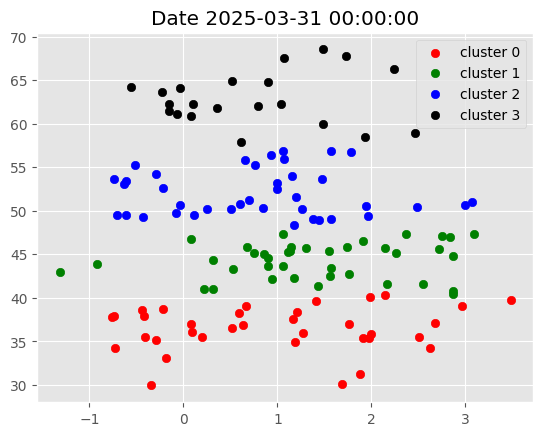

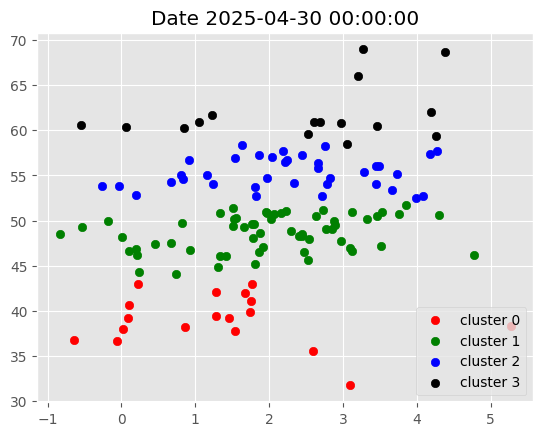

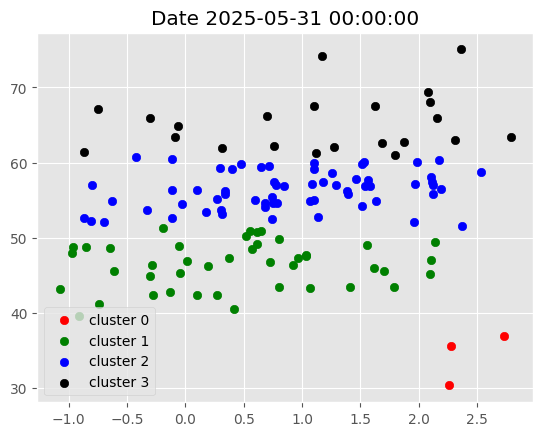

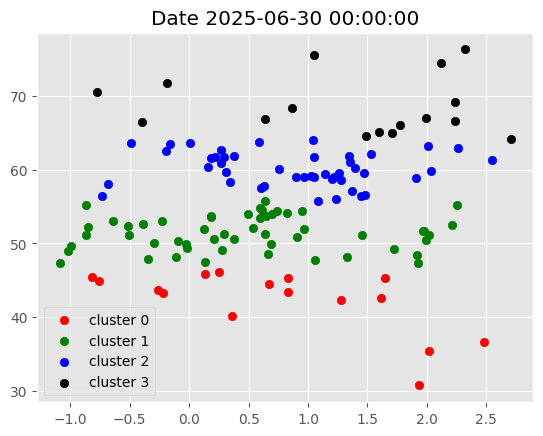

In [13]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [14]:
filtered_df = data[data['cluster']==2].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2020-07-01': ['ACN',
  'ALGN',
  'AMAT',
  'AMGN',
  'AZO',
  'BLK',
  'CMG',
  'CRM',
  'CSCO',
  'DD',
  'DE',
  'FDX',
  'HD',
  'HUM',
  'INTU',
  'LIN',
  'LLY',
  'MS',
  'MU',
  'NEM',
  'NFLX',
  'NOW',
  'NXPI',
  'ORCL',
  'PANW',
  'PG',
  'REGN',
  'SHW',
  'SPGI',
  'TMO',
  'TMUS',
  'TXN',
  'VRTX',
  'WDAY'],
 '2020-08-01': ['ADBE',
  'ADSK',
  'ALGN',
  'AMAT',
  'AMT',
  'AVGO',
  'BAC',
  'BLK',
  'BSX',
  'CAT',
  'CMCSA',
  'CMG',
  'CRM',
  'CSCO',
  'CSX',
  'DD',
  'DIS',
  'EBAY',
  'EL',
  'ELV',
  'F',
  'GOOGL',
  'HON',
  'HUM',
  'INTU',
  'KO',
  'LMT',
  'LULU',
  'MA',
  'MCD',
  'MDT',
  'MO',
  'MPC',
  'MRK',
  'MS',
  'MSFT',
  'NFLX',
  'NKE',
  'NOC',
  'NOW',
  'NSC',
  'NXPI',
  'ORCL',
  'PEP',
  'PM',
  'REGN',
  'SBUX',
  'SPGI',
  'TMUS',
  'TSLA',
  'TXN',
  'UNH',
  'UNP',
  'VZ',
  'WMT'],
 '2020-09-01': ['ADBE',
  'AMGN',
  'AMZN',
  'BKNG',
  'BLK',
  'BSX',
  'CAT',
  'CMCSA',
  'CSX',
  'DAL',
  'DHR',
  'DIS',
  'EL',
  'FIS',
  'G

In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, 0.1),
                           solver='SCS')
    weights = ef.max_sharpe()

    return ef.clean_weights()
                           
    

In [16]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1],
                    auto_adjust=False)

new_df

[*********************100%***********************]  149 of 149 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2019-07-01   48.402473   56.445198         NaN   76.084831  171.308731   
2019-07-02   48.685856   57.083473         NaN   76.499062  172.894684   
2019-07-03   49.089306   57.644852         NaN   77.120438  175.067337   
2019-07-05   49.046078   56.129906         NaN   76.922325  175.452347   
2019-07-08   48.035038   54.768749         NaN   76.625168  174.462265   
...                ...         ...         ...         ...         ...   
2025-06-23  201.500000  183.759995  130.529999  133.259995  295.000000   
2025-06-24  200.300003  185.550003  132.149994  138.080002  300.720001   
2025-06-25  201.559998  185.389999  129.669998  137.399994  294.600006   
2025-06-26  201.000000  186.789993  133.720001  133.669998  296.079987   
2025-06-27  201.080002  182.309998  134.520004  134.380005  295.459991   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2019-07-01  300.970001  103.019653  146.608948  169.289993  271.679993  ...   
2019-07-02  301.390015  101.684868  142.705582  170.100006  270.899994  ...   
2019-07-03  305.700012  101.380310  144.582382  172.000000  275.000000  ...   
2019-07-05  303.980011  101.102592  145.243179  172.229996  273.290009  ...   
2019-07-08  302.920013  100.179901  144.564743  169.869995  272.239990  ...   
...                ...         ...         ...         ...         ...  ...   
2025-06-23  380.119995  230.979996  310.239990  300.950012  183.419998  ...   
2025-06-24  382.339996  234.979996  311.399994  304.190002  186.580002  ...   
2025-06-25  387.549988  234.679993  298.190002  302.369995  187.139999  ...   
2025-06-26  384.950012  237.300003  302.980011  304.929993  187.740005  ...   
2025-06-27  385.829987  236.960007  303.450012  305.130005  188.520004  ...   

Price        Volume                                                           \
Ticker          UNP      UPS         V     VRTX        VZ     WDAY       WFC   
Date                                                                           
2019-07-01  3211800  2627600   6103200  1111500  15796800  1527200  15089100   
2019-07-02  2267700  2020200   5238100   819600  14985700  1147200  12107200   
2019-07-03  1172300  1193300   4066600   571600   8437800  1009200  10438400   
2019-07-05  2605500  1572000   5840400   878900   6938500   957200  10801600   
2019-07-08  2200700  1675300   6720300   818900  12048200  1451900  13189300   
...             ...      ...       ...      ...       ...      ...       ...   
2025-06-23  2665300  5077200   7553300   949800  16014400  1750700  17375700   
2025-06-24  2777100  3686800  10172000  1068000  16716300  2478100  16342300   
2025-06-25  2005400  6058100   6836300  1077100  15599700  1958800  13954500   
2025-06-26  2960200  4161700   8829500  1169200  15870000  2076500  18214800   
2025-06-27  7430700  5869900   6601900  3615500  21439600  1812200  21324200   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2019-07-01  16544100  3571500  11437900  
2019-07-02  12188700  1429500  10475400  
2019-07-03   9621900  1154300   5246100  
2019-07-05  10738200  1144600   6880800  
2019-07-08  14147100  1215100   7876100  
...              ...      ...       ...  
2025-06-23  20432400  1862300  26631100  
2025-06-24  22403700  1765700  24828300  
2025-06-25  11154700  1774300  17483200  
2025-06-26  19361400  1605800  18304800  
2025-06-27  31431900  2640900  22002100  

[1507 rows x 894 columns]

In [17]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]
        
        temp_df = temp_df.stack().to_frame('return').rename_axis(['Date', 'ticker']).reset_index()

        
        
        #weights_df = weights.stack().to_frame('weight').rename_axis(['ticker']).reset_index()

        

        weights_df = weights.stack().to_frame('weight').reset_index()
        weights_df.columns = ['row', 'ticker', 'weight']
        weights_df = weights_df.drop(columns='row')

        
        temp_df = temp_df.merge(weights_df, on='ticker')
        
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        
        
        temp_df = temp_df.groupby('Date')['weighted_return'].sum().to_frame('Strategy Return')

 

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

,Strategy Return
Date,
2020-07-01,0.001780
2020-07-02,0.005075
2020-07-06,0.016832
2020-07-07,0.000537
2020-07-08,0.006713
...,...
2025-06-23,0.013974
2025-06-24,0.011768
2025-06-25,-0.007918


In [18]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today(),
                 auto_adjust=False)

spy_ret = np.log(spy['Adj Close']).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.drop(
    columns=[
        'SPY', 
        'SPY_x', 
        'SPY_y', 
        'SPY Buy&Hold', 
        'Benchmark S&P 500 Returns'
    ], 
    errors='ignore'
)


portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df = portfolio_df.rename(columns={'SPY': 'Benchmark S&P 500 Returns'}).drop_duplicates()
portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,Benchmark S&P 500 Returns
Date,,
2020-07-01,0.001780,0.006980
2020-07-02,0.005075,0.005492
2020-07-06,0.016832,0.015319
2020-07-07,0.000537,-0.010368
2020-07-08,0.006713,0.007620
...,...,...
2025-06-23,0.013974,0.009829
2025-06-24,0.011768,0.010987
2025-06-25,-0.007918,0.000560


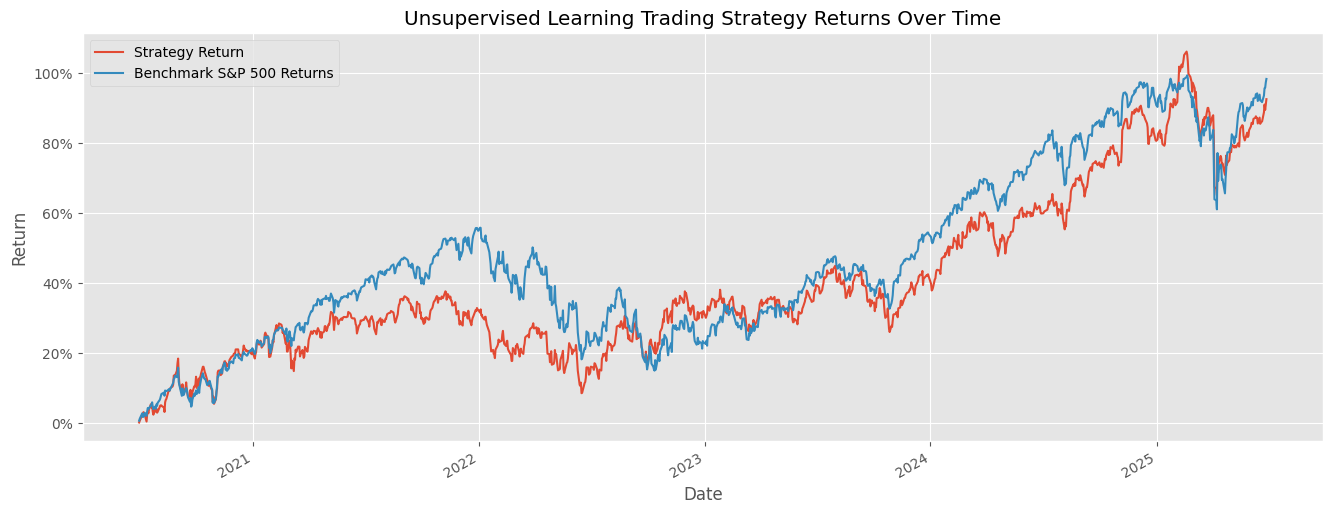

In [19]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:dt.datetime.today()].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()